### PULSAR DETECTION THROUGH REAL LARGE DATA SET USING MEAN STACKING


In [20]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import time
import statistics

#### Calculating the median requires all the data to be in memory at once. This is an issue in typical astrophysics calculations, which may use hundreds of thousands of FITS files.

#### This isn’t an issue for calculating the mean, since the sum only requires one image to be added at a time. You can load an image, add it to the sum, and then reuse the memory. Since the sum is only ever the size of a single image, you’ll never run out of memory.

### 1) Calculates the `running mean` and `stdev` for a list of FITS files using `Welford's` method

### Welford's online algorithm

It is often useful to be able to compute the variance in a `One-pass algorithm single pass`, inspecting each value $ x_i $ only once; for example, when the data is being collected without enough storage to keep all the values, or when costs of memory access dominate those of computation.  For such an `online algorithm`, a `recurrence relation` is required between quantities from which the required statistics can be calculated in a numerically stable fashion.

The following formulas can be used to update the `mean` and `(estimated) variance` of the sequence, for an additional element $x_n $. Here, $ \bar x_n $ denotes the sample mean of the first ''n'' samples $(x_1, ..., x_n), s^2_n$ their sample variance, and $ σ^2_n$ their population variance.

$$
 \bar x_n = \frac{(n-1) \, \bar x_{n-1} + x_n}{n} = \bar x_{n-1} + \frac{x_n - \bar x_{n-1}}{n}
$$

$$ 
s^2_n = \frac{n-2}{n-1} \, s^2_{n-1} + \frac{(x_n - \bar x_{n-1})^2}{n} = s^2_{n-1} + \frac{(x_n - \bar x_{n-1})^2}{n} - \frac{s^2_{n-1}}{n-1}, \quad n>1
$$

$$
\sigma^2_n = \frac{(n-1) \, \sigma^2_{n-1} + (x_n - \bar x_{n-1})(x_n - \bar x_n)}{n} = \sigma^2_{n-1} + \frac{(x_n - \bar x_{n-1})(x_n - \bar x_n) - \sigma^2_{n-1}}{n}.
$$

These formulas suffer from numerical instability, as they repeatedly subtract a small number from a big number which scales with $n$. A better quantity for updating is the sum of squares of differences from the current mean, $ \textstyle\sum_{i=1}^n (x_i - \bar x_n)^2 $, here denoted $ M_{2,n} $:

$$
\begin{align}
M_{2,n} & = M_{2,n-1} + (x_n - \bar x_{n-1})(x_n - \bar x_n) \\[4pt]
s^2_n & = \frac{M_{2,n}}{n-1} \\[4pt]
\sigma^2_n & = \frac{M_{2,n}}{n}
\end{align}
$$


In [21]:
# Write your coding for running mean and standard deviations [WELFORD'S MODEL]
def running_stats(file_names):
    """Calculates the running mean and stdev for a list of FITS files using
    Welford's method."""
    n, s, mean = 0, 0, 0
    for filename in file_names:
        hdu_list = fits.open(filename)
        data = hdu_list[0].data
        if n == 0:
            mean = np.zeros_like(data)    # Mean Initialization 
            s = np.zeros_like(data)       # Variance Initialization

        n += 1                            # add new data no
        delta = data - mean               # delta = subtract previous mean from new data 
        mean += delta / n                 # add delta/n to previous mean to obtain current mean
        s += delta * (data - mean)        # add product of (data-previous mean) and (data-current mean) to variance
        hdu_list.close()                  # close the current file to save memory

    s /= n - 1                             # final variance squared
    np.sqrt(s, s)   # Evaluates Squareroot of s and store it to output s

    if n < 2:
        return mean, None
    else:
        return mean, s


### 2) EVALUATING `NUMPY MEDIAN` FROM FITS SAMPLE FILE AND CHECKING `TIME` AND `MEMORY REQUIRED` FOR THE OPRERATIONS

In [22]:
#### EVALUATION OF NUMPY MEDIAN OF IMAGE STACKED FILE TIME TAKEN AND MEMORY CONSUMED FOR EVALUATION #####

def median_fits(files):
    """Return median, time and memory."""
    start = time.perf_counter()
    p = [fits.open(file)[0].data for file in files]
    median = np.median(p, axis=0)
    memory = sum(array.nbytes for array in p)/1024
    end = time.perf_counter() - start
    return median, end, memory


result = median_fits(['data5/image0.fits', 'data5/image1.fits'])
print(result[0][100, 100], result[1], result[2])
  
result = median_fits(['data5/image%s.fits' % i for i in range(12)])
print(result[0][100, 100], result[1], result[2])


0.012338057160377502 0.026587997999740764 625.0
0.012102657463401556 0.04128021800033821 3750.0


### 3) ALTERNATIVE WAY TO EVALUATE `MEDIAN` OF LARGE DATA `APPROXBIN ALGORITHIM` FOR TWO DIMENSIONAL DATA ###

If there were a way to calculate a "running median" you could save space by only having one image loaded at a time. Unfortunately, there’s no way to do an exact running median, but there are ways to do it approximately.

The binapprox algorithm does just this. The idea behind it is to find the median from the data's histogram. As an example, say we have a list of 30 numbers between 7 and 16 and its histogram is:

<img src="histogram_labelled.png">

The median is the average of the 15th and 16th numbers in the ordered list (we can think of this as the 15.5th number). So, starting from the left, if we sum up the counts in the histogram bins until we get to just over 15.5 then we know the last bin we added must have contained the median.

In our example, the first 3 bins sum to 9 and the first 4 bins sum to 18, so we know that the median falls into the 4th bin (marked in red), and so it must be between 10 and 11.

We choose the middle (or midpoint) giving an estimate of 10.5.

In [23]:
def median_bins_fits(files, nbins):
    mean, std = running_stats(files)
    minval = mean - std
    maxval = mean + std
    width = 2*std/nbins
    ignored = np.zeros((200, 200))
    bins = np.zeros((200, 200, nbins))
    
    for file in files:
        with fits.open(file) as fits_file:
            data = fits_file[0].data
            for i in range(200):
                for j in range(200):
                    if data[i, j] < minval[i, j]:
                        ignored[i, j] += 1
                    elif data[i, j] < maxval[i, j]:
                        index = int((data[i, j] - minval[i, j])//width[i, j])
                        bins[i, j, index] += 1
    return mean, std, ignored, bins
    

def median_approx_fits(files, nbins):
    mean, std, ignored, dbins = median_bins_fits(files, nbins)
    minval = mean - std
    width = 2*std/nbins
    median = np.zeros((200, 200))
    k, total = 0, ignored
    
    for i in range(200):
        for j in range(200):
            for k, dbin in enumerate(dbins[i, j]):
                total[i, j] += dbin
                if total[i, j] >= (len(files) + 1)/2:
                    break
            median[i, j] = minval[i, j] + width[i, j]*(k + 0.5)
    
    return median


def main():
    fits_file_names = ['image0.fits', 'image1.fits', 'image2.fits']
    fits_files = ['data6/' + file for file in fits_file_names]
    mean, std, left_bin, bins = median_bins_fits(fits_files, 5)
    median = median_approx_fits(fits_files, 5)
    
    print(mean[100, 100])
    print(std[100, 100])
    print(left_bin[100, 100])
    print(bins[100, 100, :])
    print(median[100, 100])


main()

0.018398113548755646
0.010496325561403296
0.0
[0. 2. 0. 0. 0.]
0.014199583324194326


### 4) USING 1000 NOS OF FITS FILE FOR STACKING FORM FOLDER PULSAR_EXAMPLE_FITS_1000

#### Creating list of Image files and calling mean_fits function to create single mean fits file

In [24]:
# List the Input FITS files and Call your function to get average of the FITS files
n = 1000 # no of image file to stack, max limit 1000
file1 = ['pulsar_example_fits_1000/{}.fits'.format(str(i).zfill(4)) for i in range(n)]
mean, std, left_bin, bins = median_bins_fits(file1, 100)
median_fits_data = median_approx_fits(file1, 100)

Pulsar Detection at (RA,DEC): (101, 99)


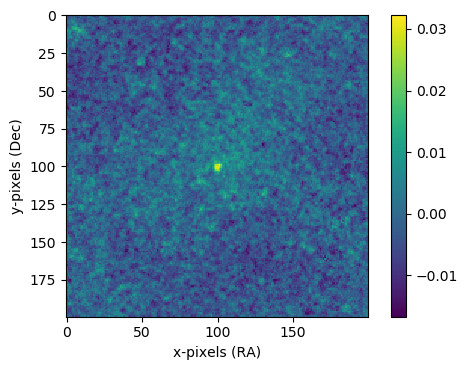

In [25]:
data = median_fits_data
ind = np.unravel_index(np.argmax(data, axis=None), data.shape)
print("Pulsar Detection at (RA,DEC):",ind)
# Plot the Average FITS File
plt.figure(dpi=100)    
plt.imshow(data.T, cmap=plt.cm.viridis)
plt.xlabel("x-pixels (RA)")
plt.ylabel("y-pixels (Dec)")
plt.colorbar()
plt.show()

### USING 7330 NOS OF FITS FILE FOR STACKING FORM FOLDER PULSAR_EXAMPLE_FITS_7330

In [ ]:
# List the Input FITS files and Call your function to get average of the FITS files
n = 7330 # no of image file to stack, max limit 7330
file2 = ['pulsar_example_fits_7330/{}.fits'.format(str(i).zfill(4)) for i in range(n)]
mean, std, left_bin, bins = median_bins_fits(file2,75)
median_fits_data = median_approx_fits(file2,75)

Pulsar Detection at (RA,DEC): (101, 99)


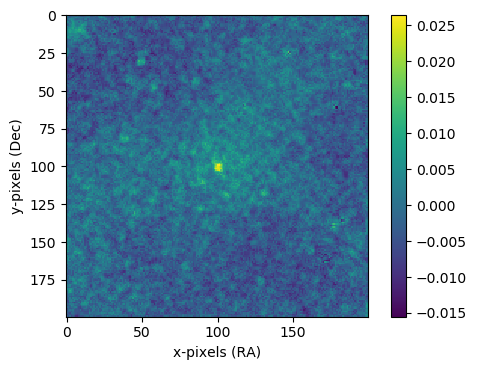

In [11]:
data = median_fits_data
ind = np.unravel_index(np.argmax(data, axis=None), data.shape)
print("Pulsar Detection at (RA,DEC):",ind)
# Plot the Average FITS File
plt.figure(dpi=100)    
plt.imshow(data.T, cmap=plt.cm.viridis)
plt.xlabel("x-pixels (RA)")
plt.ylabel("y-pixels (Dec)")
plt.colorbar()
plt.show()